# Truth Social Analytics Notebook
---
This Jupyter notebook provides a user-friendly interface to the Truthbrush CLI tool, allowing you to easily collect and analyze data from Truth Social. This tool enables researchers, analysts, and journalists to collect data from Truth Social without manual scraping,
transform raw API responses into clean pandas DataFrames, and provide an environment to visualize potential patterns in behavior or content spread.

This jupyter and pandas enviornment allows you to easily save API responses in the format of your choice; I'd recommend using parquet format.

In [19]:
import json
import subprocess
import os
import pandas as pd
from datetime import datetime
import io
from IPython.display import display, HTML

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Set Up

In [2]:
# Set your credentials here (or set them as environment variables before starting Jupyter)
def set_credentials(username=None, password=None, token=None):
    """Set Truth Social credentials for API access"""
    if token:
        os.environ["TRUTHSOCIAL_TOKEN"] = token
        print("Token set successfully.")
        return
    
    if username and password:
        os.environ["TRUTHSOCIAL_USERNAME"] = username
        os.environ["TRUTHSOCIAL_PASSWORD"] = password
        print("Username and password set successfully.")
        return
    
    print("Please provide either a token or both username and password.")

In [ ]:
# Uncomment to configure within this environment:
# set_credentials(username="your_username", password="your_password")
# or
# set_credentials(token="your_token")

## Helper Functions

In [2]:
def run_command(command):
    """Run a Truthbrush CLI command and return the result as JSON"""
    try:
        result = subprocess.run(command, capture_output=True, text=True, check=True)
        # Handle multiple JSON objects by splitting on newlines
        output_lines = result.stdout.strip().split('\n')
        json_results = []
        
        for line in output_lines:
            if line:  # Skip empty lines
                try:
                    json_results.append(json.loads(line))
                except json.JSONDecodeError:
                    print(f"Warning: Could not parse line as JSON: {line}")
        
        if len(json_results) == 1:
            return json_results[0]
        return json_results
    except subprocess.CalledProcessError as e:
        print(f"Error executing command: {e}")
        print(f"STDERR: {e.stderr}")
        return None

def json_to_df(json_data):
    """Convert JSON data to a pandas DataFrame"""
    if isinstance(json_data, list):
        # If it's already a list of records
        return pd.DataFrame(json_data)
    elif isinstance(json_data, dict):
        # If it's a dictionary, check if values are lists or primitives
        for key, value in json_data.items():
            if isinstance(value, list) and len(value) > 0:
                return pd.DataFrame(value)
        # If no list values found, treat the dict as a single record
        return pd.DataFrame([json_data])
    else:
        print(f"Unsupported data type: {type(json_data)}")
        return pd.DataFrame()

## Functions
---
### Search

In [3]:
def search_truthsocial(query, searchtype="accounts", limit=40):
    """
    Search Truth Social for users, statuses, hashtags, or groups.
    
    Parameters:
    -----------
    query : str
        The search query
    searchtype : str
        Type of search - one of "accounts", "statuses", "hashtags", or "groups"
    limit : int
        Maximum number of results to return
        
    Returns:
    --------
    pandas.DataFrame
        Search results as a DataFrame
    """
    command = ["truthbrush", "search", query, "--searchtype", searchtype, "--limit", str(limit)]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    # Search results might be a list of pages
    if isinstance(results, list):
        # Flatten the list of results
        flattened = []
        for page in results:
            if isinstance(page, list):
                flattened.extend(page)
            else:
                flattened.append(page)
        return pd.DataFrame(flattened)
    
    return json_to_df(results)

#### User Statuses

In [4]:
def get_user_statuses(username, include_replies=False, created_after=None, pinned_only=False):
    """
    Get a user's posts/statuses from Truth Social.
    
    Parameters:
    -----------
    username : str
        The username to retrieve statuses for
    include_replies : bool
        Whether to include replies in the results
    created_after : str or datetime
        Only retrieve statuses created after this date/time (ISO format)
    pinned_only : bool
        Whether to only retrieve pinned statuses
        
    Returns:
    --------
    pandas.DataFrame
        User statuses as a DataFrame
    """
    command = ["truthbrush", "statuses", username]
    
    if include_replies:
        command.append("--replies")
    else:
        command.append("--no-replies")
        
    if created_after:
        if isinstance(created_after, datetime):
            created_after = created_after.isoformat()
        command.extend(["--created-after", created_after])
        
    if pinned_only:
        command.append("--pinned")
    
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    # Results might be a list of statuses
    if isinstance(results, list):
        return pd.DataFrame(results)
    
    return json_to_df(results)

### User Information

In [5]:
def get_user_info(handle):
    """
    Get a user's profile information from Truth Social.
    
    Parameters:
    -----------
    handle : str
        The username to retrieve information for
        
    Returns:
    --------
    pandas.DataFrame
        User information as a DataFrame
    """
    command = ["truthbrush", "user", handle]
    result = run_command(command)
    
    if not result:
        return pd.DataFrame()
    
    return json_to_df(result)

### Trending Content

In [6]:
def get_trending_truths():
    """
    Get trending Truth posts.
    
    Returns:
    --------
    pandas.DataFrame
        Trending posts as a DataFrame
    """
    command = ["truthbrush", "trends"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

def get_trending_tags():
    """
    Get trending hashtags on Truth Social.
    
    Returns:
    --------
    pandas.DataFrame
        Trending hashtags as a DataFrame
    """
    command = ["truthbrush", "tags"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

### Suggested Users

In [7]:
def get_suggested_users():
    """
    Get suggested users to follow from Truth Social.
    
    Returns:
    --------
    pandas.DataFrame
        Suggested users as a DataFrame
    """
    command = ["truthbrush", "suggestions"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

### Advertisements

In [8]:
def get_ads():
    """
    Get advertisements from Truth Social.
    
    Returns:
    --------
    pandas.DataFrame
        Advertisements as a DataFrame
    """
    command = ["truthbrush", "ads"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

### Post Interactions

In [9]:
def get_post_likes(post_id, include_all=False, top_num=40):
    """
    Get users who liked a specific post.
    
    Parameters:
    -----------
    post_id : str
        The ID of the post
    include_all : bool
        Whether to include all likes (not just the top)
    top_num : int
        Number of likes to retrieve if include_all is False
        
    Returns:
    --------
    pandas.DataFrame
        Users who liked the post as a DataFrame
    """
    command = ["truthbrush", "likes", post_id, str(top_num)]
    
    if include_all:
        command.append("--includeall")
    
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    # Results might be a list of users
    if isinstance(results, list):
        return pd.DataFrame(results)
    
    return json_to_df(results)

def get_post_comments(post_id, include_all=False, only_first=False, top_num=40):
    """
    Get comments on a specific post.
    
    Parameters:
    -----------
    post_id : str
        The ID of the post
    include_all : bool
        Whether to include all comments
    only_first : bool
        Whether to only include direct replies to the post
    top_num : int
        Number of comments to retrieve if include_all is False
        
    Returns:
    --------
    pandas.DataFrame
        Comments on the post as a DataFrame
    """
    command = ["truthbrush", "comments", post_id, str(top_num)]
    
    if include_all:
        command.append("--includeall")
    
    if only_first:
        command.append("--onlyfirst")
    
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    # Results might be a list of comments
    if isinstance(results, list):
        return pd.DataFrame(results)
    
    return json_to_df(results)

### Group-Related Functions

In [10]:
def get_group_posts(group_id, limit=20):
    """
    Get posts from a group's timeline.
    
    Parameters:
    -----------
    group_id : str
        The ID of the group
    limit : int
        Maximum number of posts to retrieve
        
    Returns:
    --------
    pandas.DataFrame
        Group posts as a DataFrame
    """
    command = ["truthbrush", "groupposts", group_id, "--limit", str(limit)]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

def get_trending_groups():
    """
    Get trending groups on Truth Social.
    
    Returns:
    --------
    pandas.DataFrame
        Trending groups as a DataFrame
    """
    command = ["truthbrush", "grouptrends"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

def get_trending_group_tags():
    """
    Get trending hashtags in groups on Truth Social.
    
    Returns:
    --------
    pandas.DataFrame
        Trending group hashtags as a DataFrame
    """
    command = ["truthbrush", "grouptags"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

def get_suggested_groups():
    """
    Get suggested groups from Truth Social.
    
    Returns:
    --------
    pandas.DataFrame
        Suggested groups as a DataFrame
    """
    command = ["truthbrush", "groupsuggest"]
    results = run_command(command)
    
    if not results:
        return pd.DataFrame()
    
    return json_to_df(results)

## Data Analysis

In [11]:
# Example: Analyze post content
def analyze_posts(df):
    """Perform basic analysis on posts DataFrame"""
    if df.empty:
        print("No data to analyze")
        return
    
    # Check column names
    print("Available columns:", df.columns.tolist())
    
    # Basic statistics
    if 'replies_count' in df.columns:
        print(f"Average replies: {df['replies_count'].mean():.2f}")
    if 'reblogs_count' in df.columns:
        print(f"Average reblogs: {df['reblogs_count'].mean():.2f}")
    if 'favourites_count' in df.columns:
        print(f"Average favorites: {df['favourites_count'].mean():.2f}")
    
    # Most popular posts
    if 'favourites_count' in df.columns:
        print("\nTop 3 posts by favorites:")
        top_posts = df.sort_values('favourites_count', ascending=False).head(3)
        for _, row in top_posts.iterrows():
            print(f"- {row.get('content', '').strip()[:100]}... ({row.get('favourites_count')} favorites)")
    
    # Time analysis
    if 'created_at' in df.columns:
        df['created_at'] = pd.to_datetime(df['created_at'])
        df['hour'] = df['created_at'].dt.hour
        
        print("\nPosts by hour of day:")
        hour_counts = df['hour'].value_counts().sort_index()
        for hour, count in hour_counts.items():
            print(f"{hour:02d}:00 - {hour:02d}:59: {count} posts")

In [12]:
# DEMO:
posts_df = get_user_statuses("ProudBoysStatenIsland", include_replies=True)
posts_df.to_parquet("ProudBoysStatenIsland.parquet")
analyze_posts(posts_df)

Available columns: ['id', 'created_at', 'in_reply_to_id', 'quote_id', 'in_reply_to_account_id', 'sensitive', 'spoiler_text', 'visibility', 'language', 'uri', 'url', 'content', 'account', 'media_attachments', 'mentions', 'tags', 'card', 'group', 'quote', 'in_reply_to', 'reblog', 'sponsored', 'replies_count', 'reblogs_count', 'favourites_count', 'reaction', 'upvotes_count', 'downvotes_count', 'favourited', 'reblogged', 'muted', 'pinned', 'bookmarked', 'poll', 'emojis', 'votable', '_pulled']
Average replies: 1.79
Average reblogs: 7.19
Average favorites: 16.06

Top 3 posts by favorites:
- <p>Please Pray for our Brother. 🙏 We need him home.  His baby girl needs him more than anyone.  If y... (323 favorites)
- <p></p>... (251 favorites)
- <p></p>... (202 favorites)

Posts by hour of day:
00:00 - 00:59: 35 posts
01:00 - 01:59: 30 posts
02:00 - 02:59: 32 posts
03:00 - 03:59: 15 posts
04:00 - 04:59: 14 posts
05:00 - 05:59: 7 posts
06:00 - 06:59: 3 posts
07:00 - 07:59: 1 posts
11:00 - 11:59: 3 p

## Helper Functions for Visualization

In [13]:
def plot_engagement_metrics(df):
    """Create a bar chart of engagement metrics for posts"""
    if df.empty:
        print("No data to visualize")
        return
    
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Check if necessary columns exist
        engagement_cols = ['replies_count', 'reblogs_count', 'favourites_count']
        available_cols = [col for col in engagement_cols if col in df.columns]
        
        if not available_cols:
            print("No engagement metrics found in the DataFrame")
            return
        
        # Create a new DataFrame for plotting
        plot_df = df[available_cols].sum().reset_index()
        plot_df.columns = ['Metric', 'Count']
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Metric', y='Count', data=plot_df)
        plt.title('Total Engagement Metrics')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Please install matplotlib and seaborn to use this function")

def plot_posting_time_distribution(df):
    """Create a histogram of posting times"""
    if df.empty:
        print("No data to visualize")
        return
    
    if 'created_at' not in df.columns:
        print("No 'created_at' column found in the DataFrame")
        return
    
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Convert to datetime if needed
        df['created_at'] = pd.to_datetime(df['created_at'])
        
        # Extract hour of day
        df['hour'] = df['created_at'].dt.hour
        
        plt.figure(figsize=(12, 6))
        sns.histplot(data=df, x='hour', bins=24, discrete=True)
        plt.title('Distribution of Posts by Hour of Day')
        plt.xlabel('Hour of Day (24-hour format)')
        plt.ylabel('Number of Posts')
        plt.xticks(range(0, 24))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Please install matplotlib and seaborn to use this function")


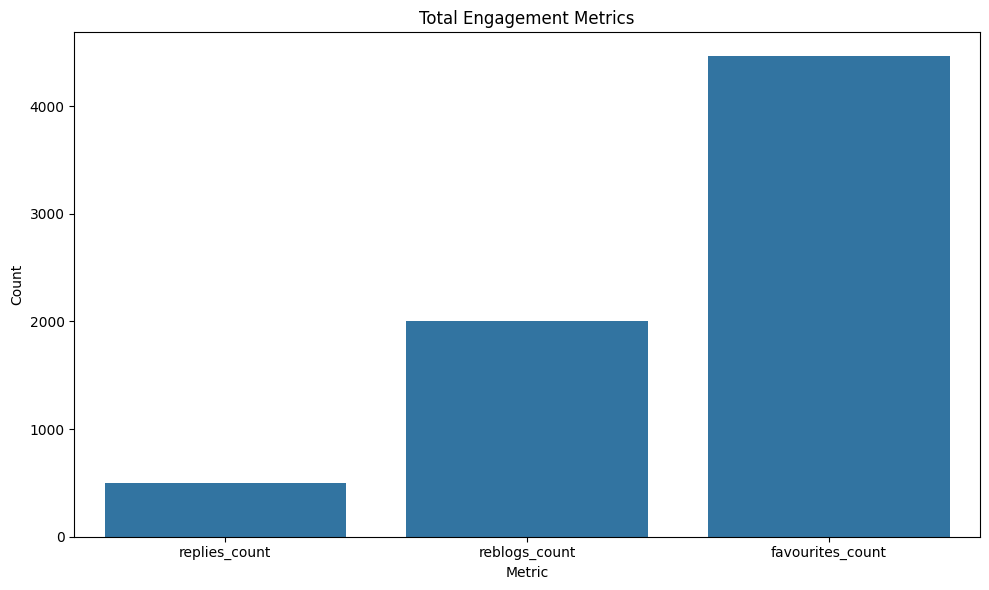

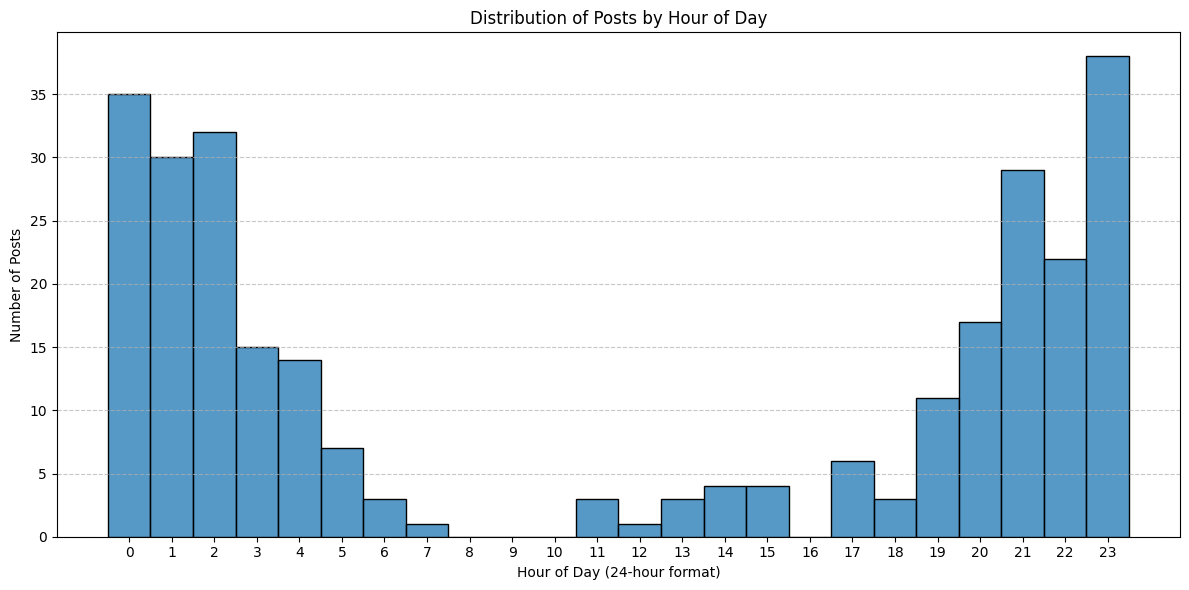

In [14]:
# DEMO:
# posts_df = get_user_statuses("ProudBoysStatenIsland", include_replies=True)
plot_engagement_metrics(posts_df)
plot_posting_time_distribution(posts_df)

In [24]:

#[print(x) for x in posts_df['url']]

#[print(x) for x in posts_df['reblog']]


posts_df

,id,created_at,in_reply_to_id,quote_id,in_reply_to_account_id,sensitive,spoiler_text,visibility,language,uri,url,content,account,media_attachments,mentions,tags,card,group,quote,in_reply_to,reblog,sponsored,replies_count,reblogs_count,favourites_count,reaction,upvotes_count,downvotes_count,favourited,reblogged,muted,pinned,bookmarked,poll,emojis,votable,_pulled,hour
0,114440240059693683,2025-05-02 20:58:03.331000+00:00,None,None,None,False,,public,None,https://truthsocial.com/@ProudBoysStatenIsland...,https://truthsocial.com/@ProudBoysStatenIsland...,"<p>RT <span class=""h-card""><a href=""https://tr...","{'id': '108388992833818883', 'username': 'Prou...",[],[],[],None,None,None,None,"{'id': '114373053865000820', 'created_at': '20...",False,0,0,0,None,0,0,False,False,False,False,False,None,[],False,2025-05-06T14:15:32.146582,20
1,114440237625708705,2025-05-02 20:57:26.193000+00:00,None,None,None,False,,public,None,https://truthsocial.com/@ProudBoysStatenIsland...,https://truthsocial.com/@ProudBoysStatenIsland...,"<p>RT <span class=""h-card""><a href=""https://tr...","{'id': '108388992833818883', 'username': 'Prou...",[],[],[],None,None,None,None,"{'id': '112379888212966964', 'created_at': '20...",False,0,0,0,None,0,0,False,False,False,False,False,None,[],False,2025-05-06T14:15:32.148621,20
2,114440235211182617,2025-05-02 20:56:49.350000+00:00,None,None,None,False,,public,None,https://truthsocial.com/@ProudBoysStatenIsland...,https://truthsocial.com/@ProudBoysStatenIsland...,"<p>RT <span class=""h-card""><a href=""https://tr...","{'id': '108388992833818883', 'username': 'Prou...",[],[],[],None,None,None,None,"{'id': '113676835470498057', 'created_at': '20...",False,0,0,0,None,0,0,False,False,False,False,False,None,[],False,2025-05-06T14:15:32.149536,20
3,114373053865000820,2025-04-21 00:11:43.361000+00:00,None,None,None,False,,public,en,https://truthsocial.com/@ProudBoysStatenIsland...,https://truthsocial.com/@ProudBoysStatenIsland...,<p>Join your Brothers today👌 If you are in N...,"{'id': '108388992833818883', 'username': 'Prou...","[{'id': '114373049862665960', 'type': 'image',...",[],"[{'name': 'MAGA'}, {'name': 'Trump'}, {'name':...",None,None,None,None,None,False,0,4,13,None,13,0,False,False,False,False,False,None,[],False,2025-05-06T14:15:32.150826,0
4,114281264144303566,2025-04-04 19:08:23.374000+00:00,None,None,None,False,,public,None,https://truthsocial.com/@ProudBoysStatenIsland...,https://truthsocial.com/@ProudBoysStatenIsland...,"<p>RT <span class=""h-card""><a href=""https://tr...","{'id': '108388992833818883', 'username': 'Prou...",[],[],[],None,None,None,None,"{'id': '114280918823470173', 'created_at': '20...",False,0,0,0,None,0,0,False,False,False,False,False,None,[],False,2025-05-06T14:15:32.151713,19
5,114280363276538210,2025-04-04 15:19:17.224000+00:00,None,None,None,False,,public,None,https://truthsocial.com/@ProudBoysStatenIsland...,https://truthsocial.com/@ProudBoysStatenIsland...,"<p>RT <span class=""h-card""><a href=""https://tr...","{'id': '108388992833818883', 'username': 'Prou...",[],[],[],None,None,None,None,"{'id': '112821004558396305', 'created_at': '20...",False,0,0,0,None,0,0,False,False,False,False,False,None,[],False,2025-05-06T14:15:32.152834,15
6,114217384165606456,2025-03-24 12:22:52.253000+00:00,None,None,None,False,,public,None,https://truthsocial.com/@ProudBoysStatenIsland...,https://truthsocial.com/@ProudBoysStatenIsland...,"<p>RT <span class=""h-card""><a href=""https://tr...","{'id': '108388992833818883', 'username': 'Prou...",[],[],[],None,None,None,None,"{'id': '114206946650494142', 'created_at': '20...",False,0,0,0,None,0,0,False,False,False,False,False,None,[],False,2025-05-06T14:15:32.154677,12
7,114145518612047768,2025-03-11 19:46:30.931000+00:00,None,None,None,False,,public,None,https://truthsocial.com/@ProudBoysStatenIsland...,https://truthsocial.com/@ProudBoysStatenIsland...,"<p>RT <span class=""h-card""><a href=""https://tr...","{'id': '108388992833818883', 'username': 'Prou.

## Stretch Goal - Recursive Account Dossier Generation?

In [25]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from datetime import datetime, timedelta
import time

In [26]:
def create_account_dossier(handle, max_posts=200, include_content=True):
    """
    Create a comprehensive dossier for a Truth Social account.
    
    Parameters:
    -----------
    handle : str
        The username/handle to analyze
    max_posts : int
        Maximum number of posts to analyze
    include_content : bool
        Whether to include post content in the dossier
        
    Returns:
    --------
    dict
        A JSON-serializable dossier of the account
    """
    # Get account basic info
    account_info = get_basic_account_info(handle)
    if not account_info:
        print(f"Could not retrieve info for account: {handle}")
        return None
    
    # Get account posts
    posts_df = get_user_statuses(handle, include_replies=True)
    if posts_df.empty:
        print(f"No posts found for account: {handle}")
        posts_df = pd.DataFrame()
    
    # Limit the number of posts to analyze
    if len(posts_df) > max_posts:
        posts_df = posts_df.head(max_posts)
    
    # Analyze posts to identify groups, interactions, and topics
    group_memberships = identify_group_memberships(posts_df)
    interactions = identify_account_interactions(posts_df)
    topics = identify_frequent_topics(posts_df)
    
    # Create the final dossier
    dossier = {
        "account_info": account_info,
        "group_memberships": group_memberships,
        "interactions": interactions,
        "topics": topics,
        "analysis_timestamp": datetime.now().isoformat(),
        "posts_analyzed": len(posts_df)
    }
    
    # Optionally include recent posts
    if include_content and not posts_df.empty:
        dossier["recent_posts"] = get_recent_posts_summary(posts_df)
    
    return dossier

def get_basic_account_info(handle):
    """
    Get basic account information for a Truth Social user.
    
    Parameters:
    -----------
    handle : str
        The username/handle to look up
        
    Returns:
    --------
    dict
        User account information
    """
    user_df = get_user_info(handle)
    
    if user_df.empty:
        return None
    
    # Convert DataFrame row to dict
    user_dict = user_df.iloc[0].to_dict() if len(user_df) > 0 else {}
    
    # Format the account info to a more manageable structure
    account_info = {
        "handle": handle,
        "id": user_dict.get("id", ""),
        "display_name": user_dict.get("display_name", ""),
        "bio": user_dict.get("note", ""),
        "follower_count": user_dict.get("followers_count", 0),
        "following_count": user_dict.get("following_count", 0),
        "statuses_count": user_dict.get("statuses_count", 0),
        "created_at": user_dict.get("created_at", ""),
        "verified": user_dict.get("verified", False),
        "location": user_dict.get("location", ""),
        "website": user_dict.get("website", "")
    }
    
    return account_info

def identify_group_memberships(posts_df):
    """
    Identify groups the account has posted in based on their posts.
    
    Parameters:
    -----------
    posts_df : pandas.DataFrame
        DataFrame containing the account's posts
        
    Returns:
    --------
    list
        List of group memberships with stats
    """
    if posts_df.empty:
        return []
    
    # Check if group information is available in the posts
    if 'group' not in posts_df.columns:
        return []
    
    # Extract group information from posts
    groups = []
    group_posts = posts_df[posts_df['group'].notna()]
    
    if group_posts.empty:
        return []
    
    # Count posts per group
    group_counts = Counter()
    group_info = {}
    
    for _, row in group_posts.iterrows():
        if isinstance(row['group'], dict):
            group_id = row['group'].get('id', 'unknown')
            group_counts[group_id] += 1
            
            if group_id not in group_info and row['group'].get('title'):
                group_info[group_id] = {
                    'id': group_id,
                    'title': row['group'].get('title', ''),
                    'description': row['group'].get('description', ''),
                    'member_count': row['group'].get('member_count', 0)
                }
    
    # Format the group memberships
    memberships = []
    for group_id, post_count in group_counts.most_common():
        group_data = {
            "group_id": group_id,
            "group_name": group_info.get(group_id, {}).get('title', 'Unknown Group'),
            "post_count": post_count
        }
        
        # Add description if available
        if group_id in group_info and group_info[group_id].get('description'):
            group_data["description"] = group_info[group_id]['description']
        
        # Add member count if available
        if group_id in group_info and group_info[group_id].get('member_count'):
            group_data["member_count"] = group_info[group_id]['member_count']
        
        memberships.append(group_data)
    
    return memberships

def identify_account_interactions(posts_df):
    """
    Identify accounts this user has interacted with through replies, mentions, and reposts.
    
    Parameters:
    -----------
    posts_df : pandas.DataFrame
        DataFrame containing the account's posts
        
    Returns:
    --------
    dict
        Dictionary of interaction types and the accounts involved
    """
    if posts_df.empty:
        return {
            "replies_to": [],
            "mentioned": [],
            "reposted": []
        }
    
    # Initialize counters for different types of interactions
    replies_to = Counter()
    mentioned = Counter()
    reposted = Counter()
    
    # Extract interactions from posts
    for _, post in posts_df.iterrows():
        # Check for replies
        if post.get('in_reply_to_account_id'):
            account_id = post['in_reply_to_account_id']
            account_handle = ""
            
            # Try to get the handle if in_reply_to info is available
            if isinstance(post.get('in_reply_to'), dict):
                account_handle = post['in_reply_to'].get('acct', '')
            
            replies_to[(account_id, account_handle)] += 1
        
        # Check for mentions
        if isinstance(post.get('mentions'), list):
            for mention in post['mentions']:
                if isinstance(mention, dict) and mention.get('id') and mention.get('acct'):
                    mentioned[(mention['id'], mention['acct'])] += 1
        
        # Check for reposts/reblogs
        if isinstance(post.get('reblog'), dict) and post['reblog'].get('account'):
            account = post['reblog']['account']
            if isinstance(account, dict) and account.get('id') and account.get('acct'):
                reposted[(account['id'], account['acct'])] += 1
    
    # Format the interactions
    interactions = {
        "replies_to": [
            {
                "account_id": account_id,
                "handle": handle,
                "reply_count": count
            } for (account_id, handle), count in replies_to.most_common()
        ],
        "mentioned": [
            {
                "account_id": account_id,
                "handle": handle,
                "mention_count": count
            } for (account_id, handle), count in mentioned.most_common()
        ],
        "reposted": [
            {
                "account_id": account_id,
                "handle": handle,
                "repost_count": count
            } for (account_id, handle), count in reposted.most_common()
        ]
    }
    
    return interactions

def identify_frequent_topics(posts_df):
    """
    Identify frequent topics/hashtags mentioned in the account's posts.
    
    Parameters:
    -----------
    posts_df : pandas.DataFrame
        DataFrame containing the account's posts
        
    Returns:
    --------
    list
        List of frequent topics with counts
    """
    if posts_df.empty:
        return []
    
    # Extract hashtags from posts
    hashtags = Counter()
    
    for _, post in posts_df.iterrows():
        if isinstance(post.get('tags'), list):
            for tag in post['tags']:
                if isinstance(tag, dict) and tag.get('name'):
                    hashtags[tag['name'].lower()] += 1
    
    # Format the topics
    topics = [
        {
            "tag": tag,
            "count": count
        } for tag, count in hashtags.most_common(20)  # Limit to top 20
    ]
    
    return topics

def get_recent_posts_summary(posts_df, max_posts=10):
    """
    Get a summary of the account's recent posts.
    
    Parameters:
    -----------
    posts_df : pandas.DataFrame
        DataFrame containing the account's posts
    max_posts : int
        Maximum number of posts to include
        
    Returns:
    --------
    list
        List of recent posts with metadata
    """
    if posts_df.empty:
        return []
    
    # Sort by date (newest first) and limit to max_posts
    sorted_posts = posts_df.sort_values('created_at', ascending=False).head(max_posts)
    
    # Format the posts
    posts_summary = []
    for _, post in sorted_posts.iterrows():
        # Determine post type
        post_type = "post"
        if post.get('reblog'):
            post_type = "repost"
        elif post.get('in_reply_to_id'):
            post_type = "reply"
        
        # Create post summary
        post_summary = {
            "id": post.get('id', ''),
            "created_at": post.get('created_at', ''),
            "type": post_type,
            "content": post.get('content', ''),
            "url": post.get('url', ''),
            "engagement": {
                "replies": post.get('replies_count', 0),
                "reposts": post.get('reblogs_count', 0),
                "likes": post.get('favourites_count', 0)
            }
        }
        
        # Add group info if available
        if isinstance(post.get('group'), dict) and post['group'].get('id'):
            post_summary["group"] = {
                "id": post['group'].get('id', ''),
                "title": post['group'].get('title', '')
            }
        
        posts_summary.append(post_summary)
    
    return posts_summary

In [39]:
def build_network_map(seed_handle, max_depth=2, max_connections=10, max_posts=100):
    """
    Build a network map starting from a seed account, exploring connections to specified depth.
    
    Parameters:
    -----------
    seed_handle : str
        The username/handle to start from
    max_depth : int
        Maximum recursion depth for network exploration
    max_connections : int
        Maximum number of connections to follow at each level
    max_posts : int
        Maximum number of posts to analyze per account
        
    Returns:
    --------
    dict
        A JSON-serializable network map with account dossiers
    """
    print(f"Building network map starting from @{seed_handle}...")
    
    # Track visited accounts to avoid loops
    visited = set()
    
    # Network map structure
    network = {
        "seed_account": seed_handle,
        "generated_at": datetime.now().isoformat(),
        "max_depth": max_depth,
        "accounts": {},
        "connections": []
    }
    
    def explore_account(handle, depth):
        """Recursive helper to explore an account and its connections"""
        if handle in visited or depth > max_depth:
            return
        
        print(f"Exploring @{handle} (depth {depth}/{max_depth})...")
        visited.add(handle)
        
        # Get account dossier
        dossier = create_account_dossier(handle, max_posts=max_posts)
        if not dossier:
            return
        
        # Add to network
        network["accounts"][handle] = dossier
        
        # Add connections based on interactions
        if "interactions" in dossier:
            # Add connections from replies
            for reply in dossier["interactions"].get("replies_to", []):
                if reply.get("handle") and reply.get("reply_count", 0) > 0:
                    add_connection(network["connections"], handle, reply["handle"], 
                                  reply["reply_count"], "reply")
                elif reply.get("account_id") and reply.get("reply_count", 0) > 0:
                    # Try to find handle from account ID
                    target_handle = find_handle_for_account_id(dossier, reply["account_id"])
                    if target_handle:
                        add_connection(network["connections"], handle, target_handle, 
                                      reply["reply_count"], "reply")
            
            # Add connections from mentions
            for mention in dossier["interactions"].get("mentioned", []):
                if mention.get("handle") and mention.get("mention_count", 0) > 0:
                    add_connection(network["connections"], handle, mention["handle"], 
                                  mention["mention_count"], "mention")
            
            # Add connections from reposts
            for repost in dossier["interactions"].get("reposted", []):
                if repost.get("handle") and repost.get("repost_count", 0) > 0:
                    add_connection(network["connections"], handle, repost["handle"], 
                                  repost["repost_count"], "repost")
        
        # Stop exploration at max depth
        if depth >= max_depth:
            return
        
        # Find top connections to explore next
        connections = []
        
        # Collect all potential connections with weights
        if "interactions" in dossier:
            # Add from replies
            for reply in dossier["interactions"].get("replies_to", []):
                if reply.get("handle") and reply.get("reply_count", 0) > 0:
                    connections.append((reply["handle"], reply["reply_count"], "reply"))
            
            # Add from mentions
            for mention in dossier["interactions"].get("mentioned", []):
                if mention.get("handle") and mention.get("mention_count", 0) > 0:
                    connections.append((mention["handle"], mention["mention_count"], "mention"))
            
            # Add from reposts
            for repost in dossier["interactions"].get("reposted", []):
                if repost.get("handle") and repost.get("repost_count", 0) > 0:
                    connections.append((repost["handle"], repost["repost_count"], "repost"))
        
        # Sort by interaction count and take top max_connections
        connections.sort(key=lambda x: x[1], reverse=True)
        top_connections = connections[:max_connections]
        
        # Explore connections recursively
        for target_handle, _, _ in top_connections:
            if target_handle and target_handle not in visited:
                # Add rate limiting to avoid API throttling
                time.sleep(2)  # Sleep 2 seconds between requests
                explore_account(target_handle, depth + 1)
    
    # Start exploration from the seed account
    explore_account(seed_handle, 1)
    
    print(f"Network map complete. Explored {len(network['accounts'])} accounts with {len(network['connections'])} connections.")
    return network

def find_handle_for_account_id(dossier, account_id):
    """
    Attempts to find a handle for an account ID by looking through all interactions.
    
    Parameters:
    -----------
    dossier : dict
        The account dossier data
    account_id : str
        The account ID to find a handle for
        
    Returns:
    --------
    str
        The handle if found, empty string otherwise
    """
    # Check mentioned accounts
    for mention in dossier["interactions"].get("mentioned", []):
        if mention.get("account_id") == account_id and mention.get("handle"):
            return mention["handle"]
    
    # Check reposted accounts
    for repost in dossier["interactions"].get("reposted", []):
        if repost.get("account_id") == account_id and repost.get("handle"):
            return repost["handle"]
    
    return ""

def add_connection(connections, source, target, weight, conn_type):
    """
    Adds a connection to the connections list, avoiding duplicates.
    
    Parameters:
    -----------
    connections : list
        The list of connections
    source : str
        Source handle
    target : str
        Target handle
    weight : int
        Connection weight
    conn_type : str
        Connection type
    """
    # Skip self-references
    if source == target:
        return
    
    # Check if connection already exists
    for conn in connections:
        if conn["source"] == source and conn["target"] == target and conn["type"] == conn_type:
            # Update weight if higher
            if weight > conn["weight"]:
                conn["weight"] = weight
            return
    
    # Add new connection
    connections.append({
        "source": source,
        "target": target,
        "weight": weight,
        "type": conn_type
    })

def save_network_to_json(network, filename):
    """
    Save network map to a JSON file.
    
    Parameters:
    -----------
    network : dict
        The network map
    filename : str
        Output filename
    """
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(network, f, indent=2, ensure_ascii=False)
    print(f"Network saved to {filename}")

def load_network_from_json(filename):
    """
    Load network map from a JSON file.
    
    Parameters:
    -----------
    filename : str
        Input filename
        
    Returns:
    --------
    dict
        The network map
    """
    with open(filename, 'r', encoding='utf-8') as f:
        network = json.load(f)
    return network


def visualize_network(network, output_file=None, min_weight=1):
    """
    Visualize the network map using NetworkX and matplotlib.
    
    Parameters:
    -----------
    network : dict
        The network map
    output_file : str
        Optional file path to save the visualization
    min_weight : int
        Minimum weight for connections to include
        
    Returns:
    --------
    matplotlib.figure.Figure
        The network visualization figure
    """
    # Create a NetworkX graph
    G = nx.DiGraph()
    
    # Add nodes (accounts)
    for handle, account in network["accounts"].items():
        follower_count = account["account_info"]["follower_count"]
        G.add_node(handle, size=follower_count, label=handle)
    
    # Add edges (connections)
    for conn in network["connections"]:
        if conn["weight"] >= min_weight:
            G.add_edge(
                conn["source"], 
                conn["target"], 
                weight=conn["weight"], 
                type=conn["type"]
            )
    
    # Set up plot
    plt.figure(figsize=(15, 15))
    
    # Calculate node sizes based on follower count, with min/max limits
    node_sizes = []
    for node in G.nodes():
        size = G.nodes[node].get("size", 0)
        # Scale size logarithmically, with a minimum size
        node_sizes.append(max(100, min(2000, 100 * (1 + size ** 0.5))))
    
    # Calculate edge widths based on weight
    edge_widths = [0.5 + G[u][v]["weight"] * 0.2 for u, v in G.edges()]
    
    # Position nodes using force-directed layout
    pos = nx.spring_layout(G, k=0.3, iterations=50)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.8, 
                          node_color="skyblue", edgecolors="black")
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color="gray",
                         arrowsize=15, connectionstyle="arc3,rad=0.2")
    
    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
    
    plt.title(f"Truth Social Network - Seed: @{network['seed_account']}", fontsize=16)
    plt.axis("off")
    
    if output_file:
        plt.savefig(output_file, bbox_inches="tight", dpi=300)
        print(f"Network visualization saved to {output_file}")
    
    return plt.gcf()

def create_interactive_network(network, output_file, min_weight=1):
    """
    Create an interactive network visualization using NetworkX and pyvis.
    
    Parameters:
    -----------
    network : dict
        The network map
    output_file : str
        File path to save the interactive HTML visualization
    min_weight : int
        Minimum weight for connections to include
    """
    try:
        from pyvis.network import Network
    except ImportError:
        print("pyvis package is required for interactive visualizations.")
        print("Install with: pip install pyvis")
        return
    
    # Create a NetworkX graph
    G = nx.DiGraph()
    
    # Add nodes (accounts)
    for handle, account in network["accounts"].items():
        follower_count = account["account_info"]["follower_count"]
        post_count = account["account_info"].get("statuses_count", 0)
        
        # Node metadata
        G.add_node(
            handle, 
            size=follower_count,
            title=f"@{handle}<br>Followers: {follower_count}<br>Posts: {post_count}",
            group=1  # Default group
        )
    
    # Assign groups based on community detection
    if len(G.nodes) > 3:
        try:
            # Use Louvain community detection
            import community as community_louvain
            partition = community_louvain.best_partition(G.to_undirected())
            
            # Update node groups
            for node, community_id in partition.items():
                if node in G.nodes:
                    G.nodes[node]["group"] = community_id + 1  # Start from 1 instead of 0
        except:
            pass  # Fall back to default groups if community detection fails
    
    # Add edges (connections)
    for conn in network["connections"]:
        if conn["weight"] >= min_weight:
            G.add_edge(
                conn["source"], 
                conn["target"], 
                weight=conn["weight"], 
                title=f"Type: {conn['type']}<br>Weight: {conn['weight']}",
                arrows="to"
            )
    
    # Create pyvis network from NetworkX graph
    pyvis_net = Network(height="750px", width="100%", directed=True, notebook=False)
    pyvis_net.from_nx(G)
    
    # Set physics options for better visualization
    pyvis_net.set_options("""
    {
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -50,
          "centralGravity": 0.01,
          "springLength": 100,
          "springConstant": 0.08
        },
        "maxVelocity": 50,
        "solver": "forceAtlas2Based",
        "timestep": 0.35,
        "stabilization": {
          "enabled": true,
          "iterations": 1000
        }
      },
      "interaction": {
        "tooltipDelay": 200,
        "hideEdgesOnDrag": true
      },
      "edges": {
        "color": {
          "inherit": true
        },
        "smooth": {
          "type": "dynamic",
          "roundness": 0.5
        }
      }
    }
    """)
    
    # Save the network visualization
    pyvis_net.save_graph(output_file)
    print(f"Interactive network visualization saved to {output_file}")

In [43]:
def get_affiliated_accounts(dossier, min_interaction_count=2):
    """
    Extract a list of affiliated accounts from an account dossier.
    
    Parameters:
    -----------
    dossier : dict
        The account dossier
    min_interaction_count : int
        Minimum number of interactions to consider an account affiliated
        
    Returns:
    --------
    list
        List of affiliated account handles
    """
    if not dossier or "interactions" not in dossier:
        return []
    
    affiliated = []
    
    # Add accounts from replies
    for reply in dossier["interactions"].get("replies_to", []):
        if reply.get("reply_count", 0) >= min_interaction_count and reply.get("handle"):
            affiliated.append(reply["handle"])
    
    # Add accounts from mentions
    for mention in dossier["interactions"].get("mentioned", []):
        if mention.get("mention_count", 0) >= min_interaction_count and mention.get("handle"):
            affiliated.append(mention["handle"])
    
    # Add accounts from reposts
    for repost in dossier["interactions"].get("reposted", []):
        if repost.get("repost_count", 0) >= min_interaction_count and repost.get("handle"):
            affiliated.append(repost["handle"])
    
    # Return unique list
    return list(set(affiliated))

def create_recursive_dossier(handle, output_dir, max_depth=2, max_affiliates=10):
    """
    Create dossiers recursively for an account and its affiliates.
    
    Parameters:
    -----------
    handle : str
        The username/handle to start from
    output_dir : str
        Directory to save the dossier files
    max_depth : int
        Maximum recursion depth
    max_affiliates : int
        Maximum number of affiliates to analyze per account
    
    Returns:
    --------
    dict
        Summary of the recursive dossier creation
    """
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Track processed accounts
    processed = set()
    to_process = [(handle, 1)]  # (handle, depth)
    
    summary = {
        "seed_account": handle,
        "generated_at": datetime.now().isoformat(),
        "accounts_processed": [],
        "max_depth": max_depth
    }
    
    # Process accounts recursively
    while to_process:
        current_handle, current_depth = to_process.pop(0)
        
        if current_handle in processed:
            continue
        
        print(f"Processing @{current_handle} (depth {current_depth}/{max_depth})...")
        
        # Create dossier
        dossier = create_account_dossier(current_handle)
        if not dossier:
            continue
        
        # Save dossier to file
        dossier_file = os.path.join(output_dir, f"{current_handle}.json")
        with open(dossier_file, 'w', encoding='utf-8') as f:
            json.dump(dossier, f, indent=2, ensure_ascii=False)
        
        processed.add(current_handle)
        summary["accounts_processed"].append({
            "handle": current_handle,
            "depth": current_depth,
            "file": dossier_file
        })
        
        # Stop recursion at max depth
        if current_depth >= max_depth:
            continue
        
        # Find affiliates for next level
        affiliates = get_affiliated_accounts(dossier)
        top_affiliates = affiliates[:max_affiliates]
        
        for affiliate in top_affiliates:
            if affiliate not in processed:
                to_process.append((affiliate, current_depth + 1))
    
    # Save summary
    summary_file = os.path.join(output_dir, "summary.json")
    with open(summary_file, 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)
    
    print(f"Recursive dossier complete. Processed {len(processed)} accounts.")
    return summary

def pipeline_for_truthbrush(handle, output_dir="output"):
    """
    Run the complete analysis pipeline and export data for TruthBrush.
    
    Parameters:
    -----------
    handle : str
        The username/handle to analyze
    output_dir : str
        Directory to save output files
    """
    import os
    import time
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print(f"=== Starting analysis for @{handle} ===")
    
    # 1. Create account dossier
    print("Creating account dossier...")
    dossier = create_account_dossier(handle)
    
    # 2. Save dossier
    dossier_file = os.path.join(output_dir, f"{handle}_dossier.json")
    with open(dossier_file, 'w', encoding='utf-8') as f:
        json.dump(dossier, f, indent=2, ensure_ascii=False)
    print(f"Dossier saved to {dossier_file}")
    
    # 3. Build network map (limited scope for initial analysis)
    print("Building network map (depth 1)...")
    network = build_network_map(handle, max_depth=1, max_connections=10)
    
    # 4. Save network data
    network_file = os.path.join(output_dir, f"{handle}_network.json")
    save_network_to_json(network, network_file)
    
    # 5. Create enhanced visualization
    viz_file = os.path.join(output_dir, f"{handle}_network.png")
    visualize_network(network, viz_file)
    
    # 6. Create interactive visualization (if pyvis is available)
    try:
        interactive_file = os.path.join(output_dir, f"{handle}_network.html")
        create_interactive_network(network, interactive_file)
    except:
        print("Skipping interactive visualization (pyvis not available)")
        interactive_file = None
    
    # 7. Export account list for further TruthBrush analysis
    accounts = list(network["accounts"].keys())
    accounts_file = os.path.join(output_dir, f"{handle}_accounts.txt")
    with open(accounts_file, 'w', encoding='utf-8') as f:
        for account in accounts:
            f.write(f"{account}\n")
    
    # 8. Export list of affiliated accounts
    affiliated = []
    for conn in network.get("connections", []):
        if conn.get("source") == handle and conn.get("target") != handle:
            affiliated.append(conn.get("target"))
        elif conn.get("target") == handle and conn.get("source") != handle:
            affiliated.append(conn.get("source"))
    
    affiliated = list(set(affiliated))  # Remove duplicates
    
    affiliated_file = os.path.join(output_dir, f"{handle}_affiliated.txt")
    with open(affiliated_file, 'w', encoding='utf-8') as f:
        for account in affiliated:
            f.write(f"{account}\n")
    
    print(f"=== Analysis complete for @{handle} ===")
    print(f"Found {len(accounts)} accounts and {len(affiliated)} affiliated accounts")
    print(f"Results saved to {output_dir}")
    print("\nTo continue analysis, you can run:")
    print(f"  - Full recursive analysis: create_recursive_dossier('{handle}', '{output_dir}/recursive')")
    print(f"  - Deeper network mapping: build_network_map('{handle}', max_depth=2, max_connections=10)")
    
    # Return summary of results
    return {
        "handle": handle,
        "dossier_file": dossier_file,
        "network_file": network_file,
        "visualization_file": viz_file,
        "interactive_file": interactive_file,
        "accounts_file": accounts_file,
        "affiliated_file": affiliated_file,
        "account_count": len(accounts),
        "affiliated_count": len(affiliated)
    }

=== Starting analysis for @ProudBoysStatenIsland ===
Creating account dossier...
Dossier saved to output/ProudBoysStatenIsland_dossier.json
Building network map (depth 1)...
Building network map starting from @ProudBoysStatenIsland...
Exploring @ProudBoysStatenIsland (depth 1/1)...
Network map complete. Explored 1 accounts with 53 connections.
Network saved to output/ProudBoysStatenIsland_network.json
Network visualization saved to output/ProudBoysStatenIsland_network.png
pyvis package is required for interactive visualizations.
Install with: pip install pyvis
=== Analysis complete for @ProudBoysStatenIsland ===
Found 1 accounts and 39 affiliated accounts
Results saved to output

To continue analysis, you can run:
  - Full recursive analysis: create_recursive_dossier('ProudBoysStatenIsland', 'output/recursive')
  - Deeper network mapping: build_network_map('ProudBoysStatenIsland', max_depth=2, max_connections=10)


{'handle': 'ProudBoysStatenIsland',
 'dossier_file': 'output/ProudBoysStatenIsland_dossier.json',
 'network_file': 'output/ProudBoysStatenIsland_network.json',
 'visualization_file': 'output/ProudBoysStatenIsland_network.png',
 'interactive_file': 'output/ProudBoysStatenIsland_network.html',
 'accounts_file': 'output/ProudBoysStatenIsland_accounts.txt',
 'affiliated_file': 'output/ProudBoysStatenIsland_affiliated.txt',
 'account_count': 1,
 'affiliated_count': 39}

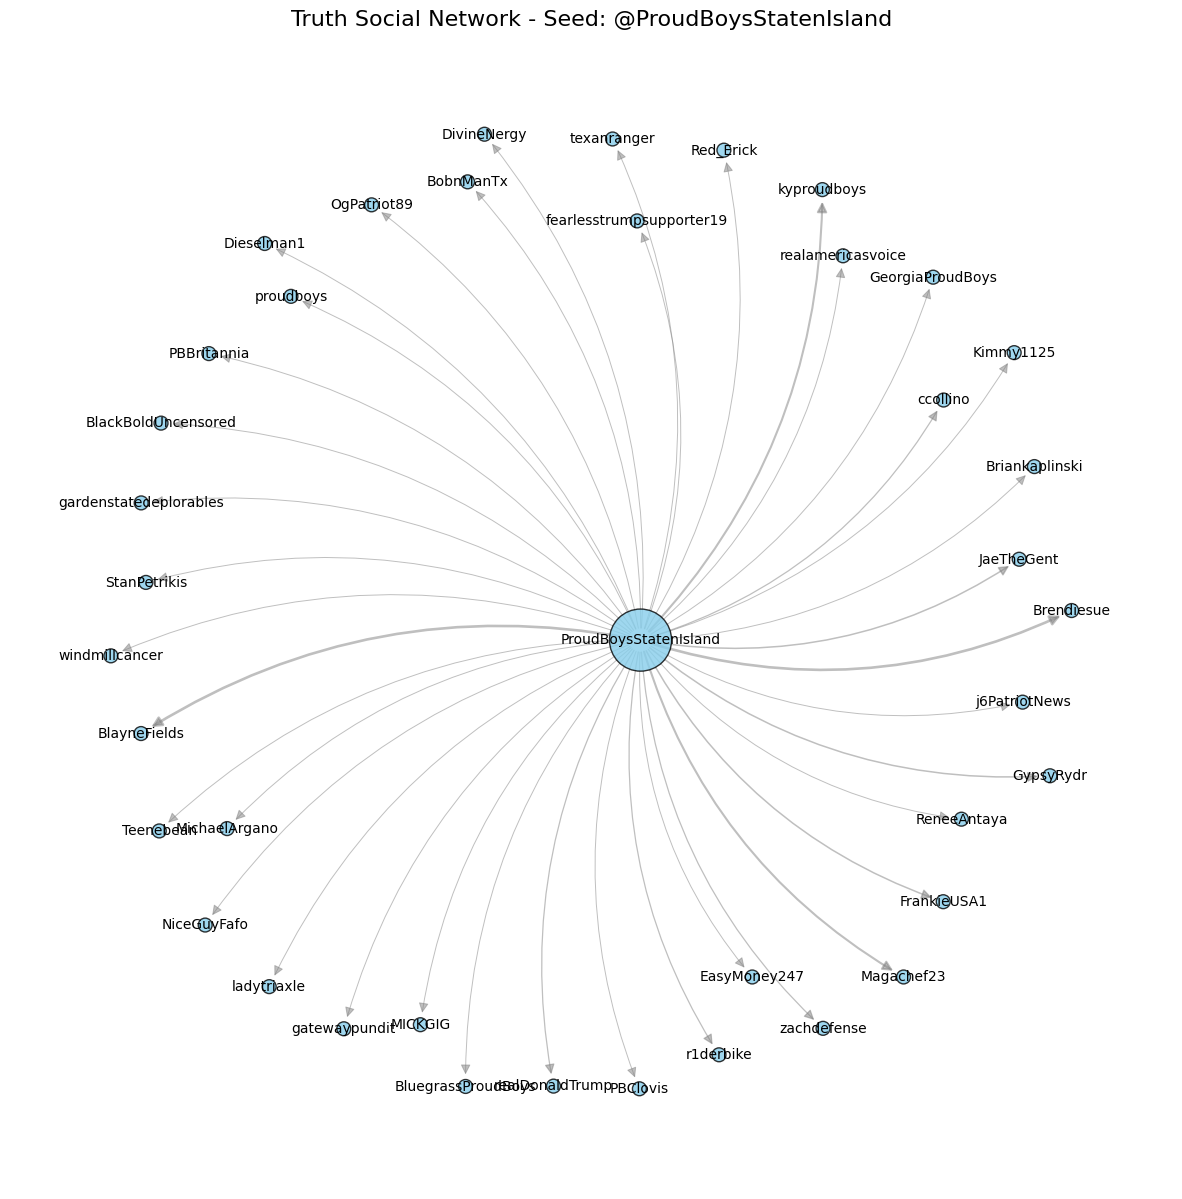

In [41]:
pipeline_for_truthbrush("ProudBoysStatenIsland", output_dir="output")

In [ ]:
# lol this will get your account suspended... Don't try this. Not without back-offs and rotating accounts...
# create_recursive_dossier("ProudBoysStatenIsland", "recursive", max_depth=2, max_affiliates=20)